# Red neuronal para estimar los inscritos para una convocatoria

### Instalación de librerias

In [ ]:
#pip install pandas psycopg2 sqlalchemy unidecode mlflow keras tensorflow seaborn statsmodels xlsxwriter 
#pip install streamlit, flask_restful flask_cors geopy folium

In [ ]:
#!pip install -r "C:\\Users\\jlmartinez\\Costos\\requeriments.txt"
#!pip install scikeras
#!pip install sklearn
#!pip install -U protobuf==3.20.*
#!pip install -U pyOpenSSL
#!pip install "numpy<2"

In [ ]:
#!pip freeze
import subprocess

output = subprocess.run(["pip", "freeze"], capture_output=True, text=True)
filtered_output = [line for line in output.stdout.splitlines() if "==" in line]
print("\n".join(filtered_output))

In [31]:
pip freeze > requeriments.txt

Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install streamlit

  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached watchdog-6.0.0-py3-none-win_amd64.whl.metadata (44 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   ---------------------------------------- 10.1/10.1 MB 52.4 MB/s  0:00:00
Using cached altair-5.5.0-py3-none-any.whl (731 kB)
Using cached pydeck-0.9.1-py2.py3-none-any.whl (6.9 MB)
Using cached tenacity-9.1.2-py3-none-any.whl (28 kB)
Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
Using cached watchdog-6.0.0-py3-none-win_amd64.whl (79 kB)

   ---------------------------------------- 0/7 [watchdog]
   ----------------- ---------------------- 3/7 [narwhals]
   ----------------- ---------------------- 3/7 [narwhals]
   ----------------- ---------------------- 3/7 [narwhals]
   ----------

# 
## Librerias Generales

In [1]:
#librerias
import io
import pandas as pd
import time
from datetime import datetime

# Maximo de columnas
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time
# Importar funciones
from src.A_Generales import lprint, load_config
from src.B_Historico import rDatosSimo, rConvocatoriaSimo
from src.C_RedNeuronal import fEscenarios, fEntrenamiento, fProyeccion
from src.D_GuardarBD import fGuardarResultados
from src.E_Resultados import fResultadosExcel, fResultadosTexto, fResultadosGraficas, rArchivoZip

CPU times: total: 10.5 s
Wall time: 8.46 s


# 
# Ejecución de la red neuronal

### Leer Histórico de SIMO

In [6]:
%%time
lprint("Inicia Pipeline \n\n")
dfEmpleo = rDatosSimo()

2025-09-29 17:06:09,414 - INFO - 2025-Sep-29-17:06:09, Inicia Pipeline 



2025-09-29 17:06:09,421 - INFO - 2025-Sep-29-17:06:09, Inicio - Crear y Leer historico de Simo

2025-09-29 17:06:09,689 - INFO - 2025-Sep-29-17:06:09, FIN de lectura de nn_simo 




CPU times: total: 203 ms
Wall time: 280 ms


### Leer los escenarios y Elaborar el diccionario

### Realiza el entrenamiento de cada escenario

In [9]:
%%time
lprint("Inicio - Realizar entrenamiento de escenarios")
Dict = fEntrenamiento(dfEmpleo, False)

2025-09-29 17:06:09,750 - INFO - 2025-Sep-29-17:06:09, Inicio - Realizar entrenamiento de escenarios

2025-09-29 17:06:09,754 - INFO - 2025-Sep-29-17:06:09, Inicio - Realizar entrenamiento de escenarios

2025-09-29 17:06:10,334 - INFO - 2025-Sep-29-17:06:10, FIN de entrenamiento de escenarios 




CPU times: total: 531 ms
Wall time: 589 ms


### Seleccionar convocatoria

In [13]:
%%time
id_convocatoria = 452897645
lprint("Inicio - Seleccionar convocatoria a proyectar")
dfCostos, co = rConvocatoriaSimo(id_convocatoria)
lprint("FIN de proyección de convocatoria")

2025-09-29 17:06:10,991 - INFO - 2025-Sep-29-17:06:10, Inicio - Seleccionar convocatoria a proyectar

2025-09-29 17:06:10,996 - INFO - 2025-Sep-29-17:06:10, Inicio - Seleccionar convocatoria a proyectar

2025-09-29 17:06:11,032 - INFO - 2025-Sep-29-17:06:11, La convocatoria es: 452897645

2025-09-29 17:06:11,053 - INFO - 2025-Sep-29-17:06:11, Consulta de la convocatoria '452897645'

2025-09-29 17:06:11,159 - INFO - 2025-Sep-29-17:06:11, Inicio consulta sql/convocatorias_unico.sql

2025-09-29 17:06:12,029 - INFO - 2025-Sep-29-17:06:12, Fin consulta sql/convocatorias_unico.sql (5, 35)

2025-09-29 17:06:12,092 - INFO - 2025-Sep-29-17:06:12, Inicio consulta sql/experiencia.sql

2025-09-29 17:06:19,020 - INFO - 2025-Sep-29-17:06:19, Fin consulta sql/experiencia.sql (167998, 10)

2025-09-29 17:06:19,053 - INFO - 2025-Sep-29-17:06:19, Cruce con los municipios y la experiencia

2025-09-29 17:06:19,091 - INFO - 2025-Sep-29-17:06:19, DataFrame de tabla public.salario_minimo

2025-09-29 17:06:19,

CPU times: total: 1.22 s
Wall time: 8.15 s


### Realizar Proyección

In [15]:
%%time
if not dfCostos.empty:
    lprint(f"Inicio - Realizar proyección de convocatoria {id_convocatoria}")
    dfCostos, Convocatoria = fProyeccion(Dict, dfCostos)
    lprint("FIN - Proyección de inscritos finalizada \n")
else:
    lprint("Convocatoria no seleccionada")

2025-09-29 17:06:19,173 - INFO - 2025-Sep-29-17:06:19, Inicio - Realizar proyección de convocatoria 452897645

2025-09-29 17:06:19,266 - INFO - 2025-Sep-29-17:06:19, DataFrame de tabla public.salario_minimo



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


2025-09-29 17:06:19,491 - INFO - 2025-Sep-29-17:06:19, Proyección realizada para el escenario Escena24-0



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025-09-29 17:06:19,637 - INFO - 2025-Sep-29-17:06:19, Proyección realizada para el escenario Escena24-0



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


2025-09-29 17:06:19,836 - INFO - 2025-Sep-29-17:06:19, Proyección realizada para el escenario Escena24-1



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


2025-09-29 17:06:19,978 - INFO - 2025-Sep-29-17:06:19, Proyección realizada para el escenario Escena24-1

2025-09-29 17:06:19,987 - INFO - 2025-Sep-29-17:06:19, FIN - Proyección de inscritos finalizada 


2025-09-29 17:06:19,992 - INFO - 2025-Sep-29-17:06:19, FIN - Proyección de inscritos finalizada 




CPU times: total: 766 ms
Wall time: 824 ms


In [16]:
dfCostos.shape

(5, 47)

### Guardar proyección en la BD

In [18]:
%%time
if not dfCostos.empty:
    lprint("Inicio - Guardar resultados en la BD")
    dfCostos, ejecucion = fGuardarResultados(Dict, dfCostos, Convocatoria, co)
    lprint("FIN - Resultados guardados en la BD \n")
else:
    lprint("Convocatoria no seleccionada")

2025-09-29 17:06:20,042 - INFO - 2025-Sep-29-17:06:20, Inicio - Guardar resultados en la BD

2025-09-29 17:06:20,050 - INFO - 2025-Sep-29-17:06:20, Inicio - Guardar resultados en la BD

2025-09-29 17:06:20,275 - INFO - 2025-Sep-29-17:06:20, Ejecucion creada: 245

2025-09-29 17:06:20,376 - INFO - 2025-Sep-29-17:06:20, Datos insertados por registros en tabla public.nn_empleo

2025-09-29 17:06:20,381 - INFO - 2025-Sep-29-17:06:20, Inicio insertar nn_stats

2025-09-29 17:06:20,504 - WARNING - 5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000014206079760> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2025-09-29 17:06:20,750 - INFO - 2025-Sep-29-17:06:20, 245/24/3/0.19282867432091455/1909.7815828186697/43.701047845774475/16.568157639890103/0.5783663878513686/0.21052308555596472/2025-09-29 22:06:20.369781+00:00/False

2025-09-29 17:06:20,754 - INFO - 2025-Sep-29-17:06:20, ANTES de conversión:

2025-09-29 17:06:20,759 - INFO - 2025-Sep-29-17:06:20, r2: 0.19282867432091455 (tipo: <class 'float'>)

2025-09-29 17:06:20,765 - INFO - 2025-Sep-29-17:06:20, mse: 1909.7815828186697 (tipo: <class 'float'>)

2025-09-29 17:06:20,770 - INFO - 2025-Sep-29-17:06:20, Dict[e]['Porc_RM']: 0.5783663878513686 (tipo: <class 'numpy.float64'>)

2025-09-29 17:06:20,776 - INFO - 2025-Sep-29-17:06:20, 
DESPUÉS de conversión:

2025-09-29 17:06:20,781 - INFO - 2025-Sep-29-17:06:20, float(r2): 0.19282867432091455 (tipo: <class 'float'>)

2025-09-29 17:06:20,781 - INFO - 2025-Sep-29-17:06:20, float(mse): 1909.7815828186697 (tipo: <class 'float'>)



116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2025-09-29 17:06:21,154 - INFO - 2025-Sep-29-17:06:21, 245/24/4/0.21795412582563767/1850.3343217265415/43.015512570775456/16.70369193437937/0.5783663878513686/0.21052308555596472/2025-09-29 22:06:20.369781+00:00/False

2025-09-29 17:06:21,159 - INFO - 2025-Sep-29-17:06:21, ANTES de conversión:

2025-09-29 17:06:21,164 - INFO - 2025-Sep-29-17:06:21, r2: 0.21795412582563767 (tipo: <class 'float'>)

2025-09-29 17:06:21,169 - INFO - 2025-Sep-29-17:06:21, mse: 1850.3343217265415 (tipo: <class 'float'>)

2025-09-29 17:06:21,174 - INFO - 2025-Sep-29-17:06:21, Dict[e]['Porc_RM']: 0.5783663878513686 (tipo: <class 'numpy.float64'>)

2025-09-29 17:06:21,179 - INFO - 2025-Sep-29-17:06:21, 
DESPUÉS de conversión:

2025-09-29 17:06:21,185 - INFO - 2025-Sep-29-17:06:21, float(r2): 0.21795412582563767 (tipo: <class 'float'>)

2025-09-29 17:06:21,190 - INFO - 2025-Sep-29-17:06:21, float(mse): 1850.3343217265415 (tipo: <class 'float'>)



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


2025-09-29 17:06:21,366 - INFO - 2025-Sep-29-17:06:21, 245/24/3/0.3315443290278255/266.9966388289694/16.34003178788124/7.827374605699019/0.15757328990228012/0.06066775244299674/2025-09-29 22:06:20.369781+00:00/True

2025-09-29 17:06:21,370 - INFO - 2025-Sep-29-17:06:21, ANTES de conversión:

2025-09-29 17:06:21,374 - INFO - 2025-Sep-29-17:06:21, r2: 0.3315443290278255 (tipo: <class 'float'>)

2025-09-29 17:06:21,378 - INFO - 2025-Sep-29-17:06:21, mse: 266.9966388289694 (tipo: <class 'float'>)

2025-09-29 17:06:21,382 - INFO - 2025-Sep-29-17:06:21, Dict[e]['Porc_RM']: 0.15757328990228012 (tipo: <class 'numpy.float64'>)

2025-09-29 17:06:21,387 - INFO - 2025-Sep-29-17:06:21, 
DESPUÉS de conversión:

2025-09-29 17:06:21,391 - INFO - 2025-Sep-29-17:06:21, float(r2): 0.3315443290278255 (tipo: <class 'float'>)

2025-09-29 17:06:21,397 - INFO - 2025-Sep-29-17:06:21, float(mse): 266.9966388289694 (tipo: <class 'float'>)



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


2025-09-29 17:06:21,547 - INFO - 2025-Sep-29-17:06:21, 245/24/4/0.4899283730299395/203.73439238680504/14.273555702305051/7.383347941889907/0.15757328990228012/0.06066775244299674/2025-09-29 22:06:20.369781+00:00/True

2025-09-29 17:06:21,552 - INFO - 2025-Sep-29-17:06:21, ANTES de conversión:

2025-09-29 17:06:21,556 - INFO - 2025-Sep-29-17:06:21, r2: 0.4899283730299395 (tipo: <class 'float'>)

2025-09-29 17:06:21,561 - INFO - 2025-Sep-29-17:06:21, mse: 203.73439238680504 (tipo: <class 'float'>)

2025-09-29 17:06:21,565 - INFO - 2025-Sep-29-17:06:21, Dict[e]['Porc_RM']: 0.15757328990228012 (tipo: <class 'numpy.float64'>)

2025-09-29 17:06:21,569 - INFO - 2025-Sep-29-17:06:21, 
DESPUÉS de conversión:

2025-09-29 17:06:21,575 - INFO - 2025-Sep-29-17:06:21, float(r2): 0.4899283730299395 (tipo: <class 'float'>)

2025-09-29 17:06:21,579 - INFO - 2025-Sep-29-17:06:21, float(mse): 203.73439238680504 (tipo: <class 'float'>)

2025-09-29 17:06:21,588 - INFO - 2025-Sep-29-17:06:21, Fin insertar n

CPU times: total: 1.17 s
Wall time: 2.11 s


### Exportar resultados en Excel, txt y pdf

2025-09-29 17:09:21,222 - INFO - 2025-Sep-29-17:09:21, Inicio - Exportar resultados a Excel y PDF

2025-09-29 17:09:21,405 - INFO - 2025-Sep-29-17:09:21, 
    SELECT
    ne.empleo_id,
    ne.concurso_ascenso,
    ne.asignacion_salarial,
    ne.agno,
    ne.smmlv,
    ne.nivel,
    ne.grado,
    ne.denominacion,
    ne.conv_padre,
    ne.conv_nombre,
    ne.entidad,
    ne.tipo_entidad,
    ne.departamento,
    ne.municipio,
    ne.codigo_dane,
    ne.mun_categoria,
    ne.vacantes_opec,
    ne.vacantes,
    ne.reqs_estudio,
    ne.experiencia,
    ne.sin_experiencia,
    
        SENA_lento.mun_inscritos SENA_lento_inscritos,
        SENA_lento.mun_aprobo_vrm SENA_lento_ins_vrm,
        SENA_lento.mun_aprobo_escritas SENA_lento_ins_esc,
        SENA_medio.mun_inscritos SENA_medio_inscritos,
        SENA_medio.mun_aprobo_vrm SENA_medio_ins_vrm,
        SENA_medio.mun_aprobo_escritas SENA_medio_ins_esc,
    ne.empleo_id
    FROM public.nn_empleo ne
     LEFT JOIN public.nn_proyeccion SEN

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2025-09-29 17:09:23,612 - WARNING - 5 out of the last 123 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001420607A980> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2025-09-29 17:09:23,714 - INFO - 2025-Sep-29-17:09:23, Archivo exportado: ./output/Resultados_245_250929_170921.txt

2025-09-29 17:09:23,739 - INFO - 2025-Sep-29-17:09:23, Se han adjuntado 3 archivos al archivo ZIP: ./output/Resultados_245_250929_170921.zip

2025-09-29 17:09:23,744 - INFO - 2025-Sep-29-17:09:23, FIN - Resultados en Excel y PDF ./output/Resultados_245_250929_170921

2025-09-29 17:09:23,749 - INFO - 2025-Sep-29-17:09:23, FIN del Pipeline



CPU times: total: 2.39 s
Wall time: 2.53 s


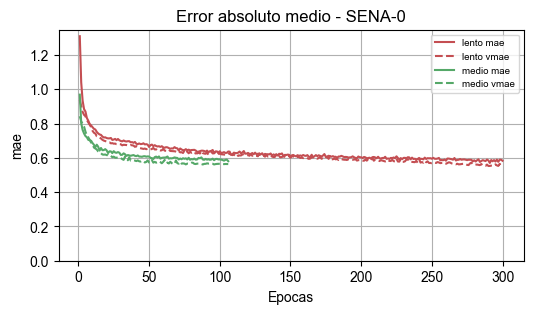

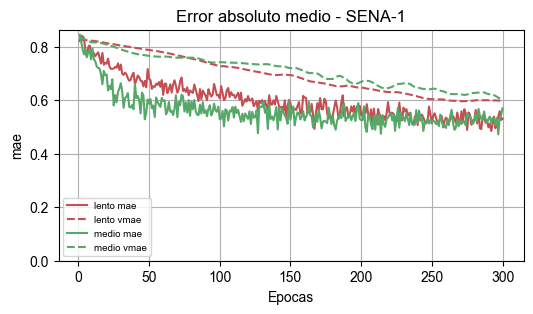

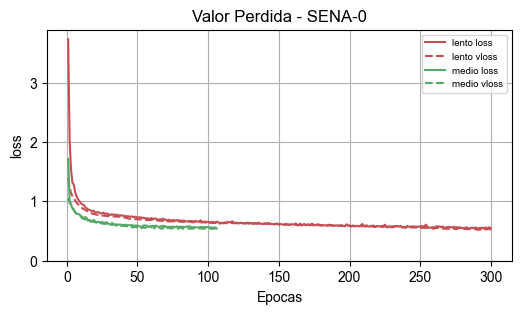

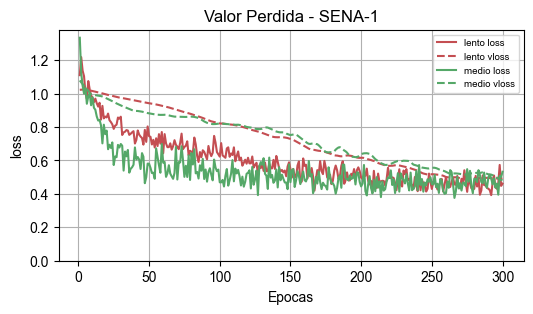

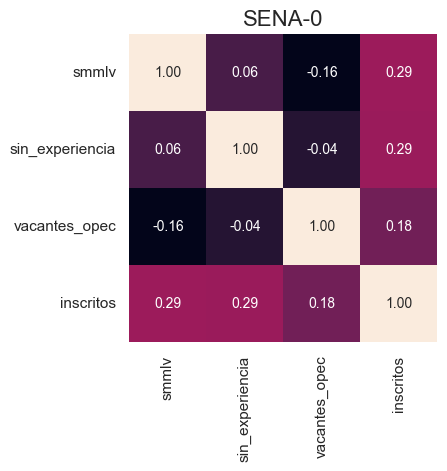

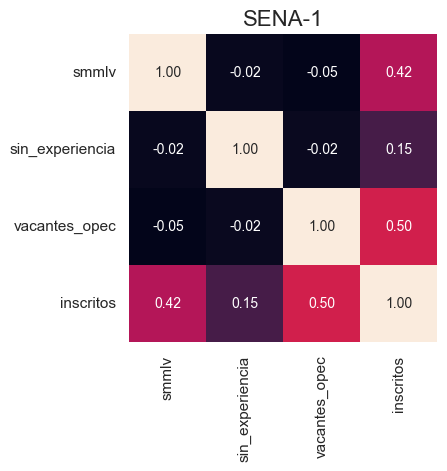

In [25]:
%%time
# ### Exportar resultados en Excel, PDF, texto
if not dfCostos.empty:
    lprint("Inicio - Exportar resultados a Excel y PDF")
    nombre = load_config()['output_dir'] + 'Resultados_' + str(ejecucion)+"_"+time.strftime("%y%m%d_%H%M%S")
    fResultadosExcel(ejecucion, nombre)
    fResultadosGraficas(Dict, dfEmpleo, nombre)
    fResultadosTexto(Dict, nombre)
    rArchivoZip(nombre)
    lprint(f"FIN - Resultados en Excel y PDF {nombre}")
else:
    lprint("Convocatoria no seleccionada")
lprint("FIN del Pipeline")

In [ ]:
base0 = Dict['Escena61']['dfModelo']
base1 = pd.concat([Dict['Escena61']['DatosX'], pd.DataFrame(Dict['Escena61']['DatosY'], columns=['inscritos'])], axis=1)
base2 = pd.DataFrame(Dict['Escena61']['X'], columns=['smmlv', 'vacantes', 'concurso_ascenso_False', 'concurso_ascenso_True',
       'reqs_estudio', 'reqs_estudio_DOCTORADO',
       'reqs_estudio_ESPECIALIZACION PROFESIONAL', 'reqs_estudio_MAESTRIA',
       'reqs_estudio_PROFESIONAL', 'reqs_estudio_TECNICO PROFESIONAL',
       'reqs_estudio_TECNOLOGICO', 'nivel', 'nivel_ASISTENCIAL',
       'nivel_PROFESIONAL', 'nivel_TECNICO'])

with pd.ExcelWriter("EjemploDatos.xlsx", engine="xlsxwriter") as writer:
    base0.to_excel(writer, sheet_name="BASE0", index=False)
    base1.to_excel(writer, sheet_name="BASE1", index=False)
    base2.to_excel(writer, sheet_name="BASE2", index=False)
    pd.DataFrame(Dict['Escena61']['Y']).to_excel(writer, sheet_name="Y", index=False)

# 
# 
### Convocatorias por Excel

#### Min Trabajo

In [ ]:
carpeta = r"D:\OneDrive - COMISIÓN NACIONAL DEL SERVICIO CIVIL\B.ProyeccionRedesNeuronales\Pruebas MinTrabajo\\"
filtro = "Reporte OPEC 4.0 Ministerio de trabajo 13-03-2024.xlsx"
dfExcel = fLeerExcel(carpeta,filtro,'BASE',0)
dfExcel.tail(3)

In [ ]:
# dfConv = dfExcel[['no_emp_simo','vacantes','municipio']]
# dfConv = dfConv.rename(columns={'no_emp_simo':'empleo_id','municipio':'cod_dane'})
# dfConv = dfConv.groupby(['empleo_id']).sum()[['vacantes']].reset_index()
# dfConv

In [ ]:
dfCostos = bdConvocatoriaExcel(dfExcel)
dfCostos = dfCostos.rename(columns={'cod_dane':'dane_entidad','xcod_dane':'cod_dane'})

dfMuni = bdMunicipio()
dfMuni = dfMuni.rename(columns={'categoria':'mun_categoria'})
dfMuni = dfMuni[['cod_dane','mun_categoria']]

dfCostos = pd.merge(dfCostos,dfMuni,on='cod_dane',how='left')

# 
# 
## Anteriores Convocatorias

#### Contraloria por excel

In [ ]:
carpeta = r"D:\OneDrive - COMISIÓN NACIONAL DEL SERVICIO CIVIL\C.Costos_ProyeccionRedesNeuronales\Pruebas Contralorias\\"
filtro = "Contralorias_20230620.xlsx"
dfConv = fLeer_excel(carpeta,filtro,'BASE',0)

#### EON noviembre

In [ ]:
carpeta = r"D:\OneDrive - COMISIÓN NACIONAL DEL SERVICIO CIVIL\C.Costos_ProyeccionRedesNeuronales\Pruebas EON\\"
filtro = "2. OPEC ENTIDADES ORDEN NACIONAL 31102023 - CON MINTIC.xlsx"
dfConv = fLeer_excel(carpeta,filtro,'EON',0)

#### Neiva

In [ ]:
carpeta = r"D:\OneDrive - COMISIÓN NACIONAL DEL SERVICIO CIVIL\C.Costos_ProyeccionRedesNeuronales\Pruebas Neiva\\"
filtro = "2023-06-01_Reporte OPEC Neiva GLPI.xlsx"
dfConv = fLeer_excel(carpeta,filtro,'BASE',0)

#### Aeronautica (Excel)

In [ ]:
carpeta = r"D:\OneDrive - COMISIÓN NACIONAL DEL SERVICIO CIVIL\C.Costos_ProyeccionRedesNeuronales\Pruebas Aerocivil\\"
filtro = "BaseAeronauticaCivil.xlsx"
dfCostos = fLeer_excel(carpeta,filtro,'BASE',0)

#### DIAN (Excel)

In [ ]:
carpeta = r"D:\OneDrive - COMISIÓN NACIONAL DEL SERVICIO CIVIL\C.Costos_ProyeccionRedesNeuronales\Prueba DIAN\\"
cArchivo = "opec.xlsx"
dfCostos = fLeer_excel(carpeta,cArchivo,'BASE',0)

#### CNSC (Excel)

In [ ]:
carpeta = r"D:\OneDrive - COMISIÓN NACIONAL DEL SERVICIO CIVIL\C.Costos_ProyeccionRedesNeuronales\Pruebas CNSC\\"
filtro = "EmpleosCNSC.xlsx"
dfConv = fLeer_excel(carpeta,filtro,'BASE',0)

#### Combinar con Experiencia y municipios

In [ ]:
dfExp2 = bdEmpleoExperiencia()
dfCostos = pd.merge(dfCostos,dfExp2, on = 'empleo_id', how= 'inner')

dfMuni = bdMunicipio()
dfMuni = dfMuni.rename(columns={'categoria':'mun_categoria'})
dfMuni = dfMuni[['cod_dane','mun_categoria']]

dfCostos = pd.merge(dfCostos,dfMuni,on='cod_dane',how='left')

#### Proyección Distrito 6

In [ ]:
%%time
empleos = dfExcel['empleo_id'].to_list()
filtro = f" empleo_id in ({', '.join(map(str, empleos))}) "
if True:
    dfConv = bdConvocatoriaSimo(filtro)
    dfExp2 = bdEmpleoExperiencia()
    dfCostos = pd.merge(dfConv,dfExp2, on = 'empleo_id', how= 'inner')

#### Proyección de  (Distrito 5)

In [ ]:
if False:
    i = dfCostos[dfCostos['cod_dane']!=11001.0].index[0]
    dfCostos.loc[i,'cod_dane'] = 11001.0
    dfCostos.loc[i,'mun_categoria'] = 7
    print(i)
    dfCostos.loc[i]

#### Convocatoria Superintendencias

In [ ]:
%%time
filtro = """ conv_id in (542826305,542826475,544389377,544389630,555496146,555697417,555697586,562145401,562145491,645785181,651454242,651454463,660546105,660546305)
"""
dfConv = bdConvocatoriaSimo(filtro)
dfExp2 = bdEmpleoExperiencia()
dfCostos = pd.merge(dfConv,dfExp2, on = 'empleo_id', how= 'inner')


#### Corregir Municipio No Aplica

In [ ]:
dfCostos[dfCostos['municipio']=='No_Aplica']

In [ ]:
if True:
    datosMun = [[660729334,19001,2],[661940241,52001,1],[660729360,5001,0],
                [645791377,70001,2],[660729266,70001,2],[661938903,70001,2]]
    for dm in datosMun:
        i = dfCostos[dfCostos['vac_id']==dm[0]].index[0]
        dfCostos.loc[i,'cod_dane'] = dm[1]
        dfCostos.loc[i,'mun_categoria'] = dm[2]

# 
# 
# 

In [ ]:
# model.evaluate(test_data, test_targets, verbose= 0)

# resultado = model.predict(test_data[0:5]).flatten()
# pd.DataFrame(resultado.astype(int), columns=['Res']) 

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import time
import sys
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from math import sqrt, isnan

In [ ]:
import gc
gc.collect()

## Visualización de resultados

In [ ]:
for e in Dict:
    print(e)

escena = list(Dict.keys())[0]
Dict[escena]['dfModelo'].tail()

#### Descripción de resultados

In [ ]:
#dfModelo['inscritos'] = np.where(( dfModelo['inscritos'].mean() < dfModelo['inscritos']),1,dfModelo.inscritos)
#dfModelo['inscritos'] = round((dfModelo['inscritos'] / maximo)*100)

#### Evaluación de Datos de Prueba y de Entrenamiento

In [ ]:
for e in Dict:
    for i, hist in enumerate(Dict[e]['Historico']):
        print("\n",Dict[e]['Filtro']," - # Neuronas: ")
        print("Evaluar datos de Prueba:")
        print(hist['model'].evaluate(Dict[e]['test_data'], Dict[e]['test_targets']),"\n")
        print("Evaluar datos de Entrenamiento:")
        print(hist['model'].evaluate(Dict[e]['train_data'], Dict[e]['train_targets']),"\n")

In [ ]:
dfCorr = dfEmpleo
plt.figure(figsize=(8,8))
sns.set(font_scale=1)
etiquetas = dfCorr.corr().columns.tolist()
hm = sns.heatmap(dfCorr.corr().to_numpy(),
                 cbar=False,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 yticklabels=etiquetas,
                 xticklabels=etiquetas)
hm.set_title('SIMO', fontsize =12)

In [ ]:
for e in Dict:
    etiquetas = Dict[e]['dfModelo'].columns.tolist()
    dfCorr = Dict[e]['dfModelo']
    plt.figure(figsize=(3,3))
    sns.set(font_scale=1)
    hm = sns.heatmap(dfCorr.corr().to_numpy(),
                     cbar=False,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 10},
                     yticklabels=etiquetas,
                     xticklabels=etiquetas)
    hm.set_title(Dict[e]['Filtro'], fontsize =16)

In [ ]:
miRango = dfEmpleo[['entidad','nivel','municipio','va_inscritos','vacantes','mun_categoria']]
miRango = miRango[~miRango['nivel'].isin(['Instructor','Directivo'])]
miRango = miRango[miRango['va_inscritos'].between(miRango['va_inscritos'].quantile(0), miRango['va_inscritos'].quantile(0.95), inclusive = True)]
sns.pairplot(miRango, hue = str('mun_categoria'))
print(miRango.shape)

In [ ]:
for e in Dict:
    miRango = Dict[e]['dfEscenario'][['smmlv','nivel','vacantes','va_inscritos']]
    miRango = miRango[miRango['va_inscritos'].between(miRango['va_inscritos'].quantile(0), miRango['va_inscritos'].quantile(1), inclusive = True)]
    sns.pairplot(miRango, hue = 'nivel')
    print(Dict[e]['Filtro'], miRango.shape)

In [ ]:
for e in Dict:
    miRango = Dict[e]['dfEscenario'][['smmlv','nivel','vacantes','va_inscritos']]
    miRango = miRango[~miRango['nivel'].isin(['Instructor','Directivo'])]
    miRango = miRango[miRango['va_inscritos'].between(miRango['va_inscritos'].quantile(0.05), miRango['va_inscritos'].quantile(0.95), inclusive = True)]
    sns.pairplot(miRango, hue = 'nivel')
    print(Dict[e]['Filtro'],miRango.shape)

##### Total de inscritos por Tipo de Entidad

In [ ]:
plt.figure(figsize=(6,4))
dfPlot = dfEmpleo.groupby('tipo_entidad')['va_inscritos'].sum().sort_values()
dfPlot.plot.pie(title='Inscritos por Tipo de Entidad');

In [ ]:
pd.DataFrame(dfPlot).sort_values(by=['va_inscritos'], ascending=False).reset_index()

#### Percentiles de inscritos por categoria del municipio

In [ ]:
for e in Dict:
    plt.figure(figsize=(5,4))
    plt.title("Inscritos por categoria del municipio - " + Dict[e]['Filtro'])
    sns.boxplot(x='mun_categoriaF',y='va_inscritos', 
            data = Dict[e]['dfModelo'][Dict[e]['dfModelo']['va_inscritos'] 
                                             < Dict[e]['dfModelo']['va_inscritos'].quantile(0.95)])
    plt.show()

#### Total de inscritos por Nivel del cargo

In [ ]:
for e in Dict:
    dfPlot = Dict[e]['dfModelo'].groupby('nivelF')['va_inscritos'].sum().sort_values(ascending=False);

    plt.xlabel("Nivel")
    plt.ylabel("# Inscritos")
    plt.title('Total inscritos por nivel - '+ Dict[e]['Filtro'])
    #plt.axis("off")
    plt.axes().get_xaxis().set_visible(False)
    x = np.arange(0,dfPlot.count(),1)
    y = dfPlot.to_numpy()
    z = dfPlot.index.to_numpy()
    plt.bar(x,y)
    for i,j,k in zip(x,y,z):
        plt.annotate(j, (i,j), textcoords="offset points", xytext=(0,0), ha='center')
        plt.annotate(int(k), (i,0), textcoords="offset points", xytext=(0,-25), ha='center', color = 'red')
    plt.show()

##### Total inscritos por SMMLV del empleo

In [ ]:
for e in Dict:
    fig = plt.figure(figsize=(8,3))
    plt.plot(Dict[e]['X'][:,4], Dict[e]['Y'], '.')
    plt.title('Total inscritos por SMMLV - '+Dict[e]['Filtro'])
    plt.xlabel('SMMLV')
    plt.ylabel('# Inscritos')
    plt.legend(['empleo'], loc='upper right')
    plt.show()

##### Total Inscritos por Vacantes del empleo

In [ ]:
for e in Dict:
    fig = plt.figure(figsize=(8,3))
    plt.plot(Dict[e]['X'][:,4], Dict[e]['Y'], '.')
    plt.title('Total Inscritos por Vacantes del empleo - '+Dict[e]['Filtro'])
    plt.xlabel('Vacantes')
    plt.ylabel('# Inscritos')
    plt.legend(['empleo'], loc='upper right')
    plt.show()

#### Inicio de la lista de OPEC

##### ver diccionarios

In [ ]:
dfS = dfEmpleo[['smmlv']]
dfS['smmlv2'] = pd.Series(list(map(lambda x: x * 2, dfEmpleo['smmlv'])))
dfS

In [ ]:
Escena = list(Dict.keys())[0]

print(Dict[Escena].keys(),'\n')
#dict_keys(['dfEscenario', 'Filtro', 'Ascenso', 'dfmun_categoria', 'dfnivel', 'dfdeno_nombre', 'dfModelo', 'dataModelo', 'entradas',
#'X', 'Y', 'train_data', 'test_data', 'train_targets', 'test_targets', 'Limites', 'num_val_samples', 'Historico'])

print(Dict[Escena]['Historico'][0].keys(),'\n')
#dict_keys(['red', 'model', 'hist', 'mae', 'vmae', 'loss', 'vloss'])

print(Dict[Escena]['Historico'][0]['red'],'\n')
#[neuronas,learnR,DropOut,epochs,batch]


# 
# 
# 

# Visualización geografica 

In [ ]:
#librerias de graficos
import seaborn as sns
import matplotlib.pyplot as plt

#librerias de geografia
from geopy.geocoders import Nominatim
import folium
#import pyspark

In [ ]:
address = 'Colombia'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of ',address,' are {}, {}.'.format(latitude, longitude))

In [ ]:
query = """select codigo codigo_dane, municipio_categoria_id, latitud, longitud, nombre from public.lugar where municipio_categoria_id is not null """
dfMuni = fConsultaScript(openCosteo()[0],query)
dfMuni.head()

In [ ]:
for e in Dict:
    print(e, Dict[e]['Filtro'])
    print(Dict[e]['dfEscenario'].shape)

In [ ]:
dfDane = Dict[escena]['dfEscenario']
dfDane = dfDane[['codigo_dane','mun_inscritos']].groupby('codigo_dane').sum('mun_inscritos')
dfDane['codigo_dane'] = dfDane.index
dfDane.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

In [ ]:
cifra = int(dfDane['mun_inscritos'].max())
cifra = (cifra,int(cifra/2))[int(str(cifra)[0]) > 4]
fraccion = 10 ** (len(str(cifra)) -2)
print(cifra,fraccion)

In [ ]:
dfMapa = pd.merge(dfMuni,dfDane,on='codigo_dane',how='left')

dfMapa = dfMapa.sort_values('mun_inscritos', ascending=False)
dfMapa = dfMapa.dropna()
dfMapa['Porc'] = round(dfMapa['mun_inscritos'] / int(dfMapa['mun_inscritos'].max()) * 25, 2)
dfMapa = dfMapa[dfMapa['Porc'] > 0]
dfMapa.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
print(dfMapa.shape)
dfMapa.head(3)

In [ ]:
map_colombia = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, label, insc, rdo in zip(dfMapa['latitud'], dfMapa['longitud'], dfMapa['nombre'], dfMapa['mun_inscritos'], dfMapa['Porc']):
    label = folium.Popup(str(label)+'-'+str(int(insc)), parse_html=True)
    folium.CircleMarker(
        [lng, lat],
        radius=rdo,
        popup=label,
        color='black',
        fill=True,
        fill_color='gold',
        fill_opacity=0.5,
        parse_html=False).add_to(map_colombia)
    
map_colombia

In [ ]:
from folium import plugins

map_colombia = folium.Map(location=[latitude, longitude], zoom_start=5,width="100%",height="100%")
locations = list(zip(dfMapa['longitud'], dfMapa['latitud']))
cluster = plugins.MarkerCluster(
    locations=locations, 
    popups=dfMapa["mun_inscritos"].tolist(), 
    name=dfMapa["nombre"].tolist(), 
    radius=dfMapa['Porc'].tolist()
)
map_colombia.add_child(cluster)
map_colombia

#folium.plugins.MarkerCluster(locations=None, popups=None, icons=None, name=None, overlay=True, 
#                             control=True, show=True, icon_create_function=None, options=None, **kwargs)

In [ ]:
from sklearn.feature_selection import f_regression

# Define the target variable
filtered_data = dfEmpleo[dfEmpleo['conv_padre_id']==554139239].copy()


y_filtered = filtered_data['mun_inscritos']

# Exclude specified columns from features
excluded_columns = ['inscritos', 'aprobo_vrm', 'aprobo_escritas', 'mun_aprobo_vrm', 'mun_aprobo_escritas', 'mun_inscritos']
selected_columns = filtered_data.columns.difference(excluded_columns)

# Splitting numerical and categorical features
numerical_cols = filtered_data[selected_columns].select_dtypes(include=['float64', 'int64','int32']).columns
categorical_cols = filtered_data[selected_columns].select_dtypes(include=['object', 'bool']).columns

# Handle numerical columns: calculate correlation with 'mun_inscritos'
numerical_corr = filtered_data[numerical_cols].corrwith(y_filtered).sort_values(ascending=False)

# Handle categorical columns: encode and evaluate ANOVA F-value
X_encoded = pd.get_dummies(filtered_data[categorical_cols], drop_first=True)
f_values, p_values = f_regression(X_encoded, y_filtered)

# Compile results for categorical variables
anova_results_cat = pd.DataFrame({
    'Feature': X_encoded.columns,
    'F-Value': f_values,
    'P-Value': p_values
}).sort_values(by='F-Value', ascending=False)

# Select the top 4 features based on correlation and F-value
top_numerical_features = numerical_corr.index.tolist()  # Top 2 numerical
top_categorical_features = anova_results_cat.head(20)['Feature'].tolist()  # Top 2 categorical

top_features = top_numerical_features + top_categorical_features
top_features


In [ ]:
X_encoded = pd.get_dummies(filtered_data[categorical_cols], drop_first=True)

In [ ]:
anova_results_cat = pd.DataFrame({
    'Feature': X_encoded.columns,
    'F-Value': f_values,
    'P-Value': p_values
}).sort_values(by='F-Value', ascending=False)

In [ ]:
anova_results_cat

In [ ]:
pd.options.display.max_rows = None

In [ ]:
# Re-import necessary libraries for computation as environment might have reset
import pandas as pd
from sklearn.feature_selection import f_classif

# Reload the dataset
#file_path = '/mnt/data/nn_simo_20241108.xlsx'
#data = pd.read_excel(file_path)

# Filter the dataset by 'conv_padre' as per previous instructions
filtered_data = dfEmpleo[dfEmpleo['conv_padre'] == "PROCESO DE SELECCION PARA MUNICIPIOS DE 5ta Y 6ta CATEGORIA"]

# Target variable
y_target = filtered_data['mun_inscritos']

# Categorical variables for ANOVA evaluation without using get_dummies
categorical_cols = [ 'nivel', 'denominacion', 'concurso_ascenso']

# Encode the categorical columns by replacing categories with mean 'mun_inscritos' (mean encoding)
for col in categorical_cols:
    mean_encoded = filtered_data.groupby(col)['mun_inscritos'].mean()
    filtered_data[f'{col}_mean_encoded'] = filtered_data[col].map(mean_encoded)

# Use the mean encoded columns for ANOVA to evaluate their significance without get_dummies
X_encoded = filtered_data[[f'{col}_mean_encoded' for col in categorical_cols]]

# Perform ANOVA F-test for these encoded columns against the target
f_values, p_values = f_classif(X_encoded, y_target)

# Compile results into a DataFrame for analysis
anova_results = pd.DataFrame({
    'Feature': X_encoded.columns,
    'F-Value': f_values,
    'P-Value': p_values
}).sort_values(by='F-Value', ascending=False)

# Display the ANOVA results
anova_results


In [ ]:
mean_encoded = filtered_data.groupby('denominacion')['mun_inscritos'].mean()
filtered_data[f'{'denominacion'}_mean'] = filtered_data['denominacion'].map(mean_encoded)

In [ ]:
from sqlalchemy.types import String

In [ ]:
  lista = fRetornaLista(openCosteo, f"""select nombre, tipo, id from {openCosteo()[1]}.np_variables where activo """)

  col_mun = ['departamento', 'municipio', 'codigo_dane', 'vacantes', 'mun_inscritos', 'mun_aprobo_vrm', 'mun_aprobo_escritas', 'mun_categoria']
  
  # si hay una variable de municipio
  if any(item in lista[0] for item in col_mun):
    df = fConsultaTabla(openCosteo, 'nn_simo')
  else:
    df = fConsultaTabla(openCosteo, 'nn_simo_unico')
    for col in col_mun:
      df[col] = None

  df = fCorregirTipoDatos(df)[0]

  if any(item in lista[0] for item in ['smmlv', 'asignacion_salarial']):
    df = df[~pd.isnull(df['smmlv'])]
    df.reset_index(drop=True, inplace=True)


In [ ]:
import pandas as pd
print(pd.__version__)

In [ ]:
import numpy as np
print(np.__version__)